In [1]:
import copy
import numpy as np
import os
import verdict
import sys

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as plt_lines
%matplotlib inline

In [3]:
import galaxy_dive.read_data.metafile as read_metafile
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.utilities as utilities
import galaxy_dive.utils.executable_helpers as exec_helpers

In [4]:
import linefinder.utils.file_management as file_management
import linefinder.analyze_data.worldline_set as worldline_set
import linefinder.analyze_data.worldlines as worldlines
import linefinder.utils.presentation_constants as p_constants
import linefinder.config as l_config

In [5]:
import analysis_config

# Load Data

In [6]:
do_calculation = False

In [7]:
snum, galdef = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef ) )

Using snum 465, galdef 


In [8]:
presentation_figure = True

In [9]:
mass_key = 'M'

In [10]:
save_file_tags = {
    'M' : 'mass',
    'metal_mass' : 'metalmass',
    'enriched_metal_mass' : 'enrichedmetalmass',
}

In [11]:
axes_labels = {
    'M' : 'Mass',
    'metal_mass' : 'Metal Mass',
    'enriched_metal_mass' : 'Metal Mass',
}

In [12]:
file_manager = file_management.FileManager( project='CGM_fate' )

In [13]:
ind = 600 - snum

In [14]:
tag_tail = '_CGM_snum{}'.format( snum )

In [15]:
defaults, variations = file_manager.get_linefinder_analysis_defaults_and_variations(
    tag_tail,
    sim_names = analysis_config.SIM_NAMES,
    galdef = galdef,
)
defaults, variations

({'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m12i_res7100/data',
  'tag': 'm12i_CGM_snum465',
  'halo_data_dir': '/scratch/03057/zhafen/core/m12i_res7100/halo',
  'ahf_index': 600,
  'main_halo_id': 0},
 {'m10q': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10q_res250/data',
   'tag': 'm10q_CGM_snum465',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10q_res250/halo',
   'ahf_index': 600,
   'main_halo_id': 0},
  'm10v': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10v_res250/data',
   'tag': 'm10v_CGM_snum465',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10v_res250/halo',
   'ahf_index': 600,
   'main_halo_id': 2},
  'm10y': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10y_res250/data',
   'tag': 'm10y_CGM_snum465',
   'halo_data_dir': '/scratch/03057/zhafen/core/m10y_res250/halo',
   'ahf_index': 600,
   'main_halo_id': 0},
  'm10z': {'data_dir': '/scratch/03057/zhafen/linefinder_data/core/m10z_res250/data',
   'tag': 'm10z_C

In [16]:
w_set = worldline_set.WorldlineSet( defaults, variations )

In [17]:
default_sim_name = list( w_set.keys() )[0]

In [18]:
w = w_set[default_sim_name]

In [19]:
classifications = copy.deepcopy( p_constants.CLASSIFICATIONS_CGM_FATE )
classifications.append( 'is_in_CGM_not_sat' )
classifications.append( 'is_CGM_fate_unclassified' )
classifications += p_constants.CLASSIFICATIONS_LOCATION

In [20]:
metafile_reader = read_metafile.MetafileReader(
    file_manager.get_metafile_dir( default_sim_name )
)

In [21]:
p_constants.CLASSIFICATIONS_LOCATION

['is_in_main_gal',
 'is_in_galaxy_halo_interface',
 'is_in_CGM',
 'is_in_IGM',
 'is_in_other_gal_outside_CGM',
 'is_in_other_CGM_not_main']

In [22]:
classifications

['is_CGM_still',
 'is_CGM_accreted',
 'is_CGM_accreted_to_satellite',
 'is_CGM_ejected',
 'is_CGM_halo_transfer',
 'is_in_CGM_not_sat',
 'is_CGM_fate_unclassified',
 'is_in_main_gal',
 'is_in_galaxy_halo_interface',
 'is_in_CGM',
 'is_in_IGM',
 'is_in_other_gal_outside_CGM',
 'is_in_other_CGM_not_main']

# Analyze Data

### Get masses out

#### Mass Fractions

In [23]:
def choose_slice( classification ):
        
    if classification in p_constants.CLASSIFICATIONS_LOCATION:
        i_ind = 0
    else:
        i_ind = ind
        
    return ( slice(None), i_ind )

In [24]:
if do_calculation:
    
    CGM_selection = 'is_in_CGM'
#     CGM_selection = 'is_in_CGM_not_sat'
    
    CGM_mass_fractions_fate = {}
    CGM_mass_fractions_joint = {}

    for sim_name in w_set.keys():
        
        print( sim_name )
        
        w = w_set[sim_name].data_object
        
        # Make a mask for gas (not stars) that is in the CGM
        is_in_CGM_at_target = w.get_processed_data( 'is_in_CGM', sl=(slice(None),ind), )
        is_gas_at_target = w.get_processed_data( 'PType', sl=(slice(None),ind) ) == l_config.PTYPE_GAS
        is_in_CGM_at_target = is_in_CGM_at_target & is_gas_at_target
        is_in_CGM_at_target_tiled = np.tile( is_in_CGM_at_target, ( w.n_snaps, 1 ) ).transpose()
        w.data_masker.mask_data(
            'is_in_CGM',
            custom_mask = np.invert( is_in_CGM_at_target_tiled ),
            optional_mask = True,
            mask_name = 'in_CGM',
        )
        
        # Make temperature masks
        w.data_masker.mask_data(
            'T',
            0.,
            10.**5.3,
            optional_mask = True,
            mask_name = 'cool',
        )
        w.data_masker.mask_data(
            'T',
            10.**5.3,
            np.inf,
            optional_mask = True,
            mask_name = 'hot',
        )
        optional_masks = {
            'all': [ 'in_CGM', ],
            'cool': [ 'in_CGM', 'cool', ],
            'hot': [ 'in_CGM', 'hot', ],
        }
        
        for temp_cut in [ 'all', 'cool', 'hot' ]:
            try:
                CGM_mass_fractions_fate[temp_cut]
                CGM_mass_fractions_joint[temp_cut]
            except KeyError:
                CGM_mass_fractions_fate[temp_cut] = {}
                CGM_mass_fractions_joint[temp_cut] = {}

            normalization_mass = w.get_selected_quantity(
                selection_routine = CGM_selection,
                ptype = None,
                sl = (slice(None),ind),
                selected_quantity_data_key = mass_key,
                optional_masks = [ 'in_CGM' ],
            )

            # See what different fates consist of
            for classification in classifications:
                
                # Choose what gas to select
                if classification in p_constants.CLASSIFICATIONS_LOCATION:
                    c_selection_routine = classification
                else:
                    c_selection_routine = [ classification, CGM_selection ]

                # Get mass fraction
                mass = w.get_selected_quantity(
                    selection_routine = c_selection_routine,
                    ptype = None,
                    sl = choose_slice( classification ),
                    selected_quantity_data_key = mass_key,
                    optional_masks = optional_masks[temp_cut],
                )
                try:
                    mass_frac = mass / normalization_mass
                except ZeroDivisionError:
                    np.testing.assert_allclose( mass, 0. )
                    mass_frac = 0.0

                # Store the data
                try:
                    CGM_mass_fractions_fate[temp_cut][classification]
                    CGM_mass_fractions_joint[temp_cut][classification]
                except KeyError:
                    CGM_mass_fractions_fate[temp_cut][classification] = verdict.Dict( {} )
                    CGM_mass_fractions_joint[temp_cut][classification] = verdict.Dict( {} )
                CGM_mass_fractions_fate[temp_cut][classification][sim_name] = mass_frac

                # Look at relationship between origin and fate
                inner_classifications = (
                    p_constants.CLASSIFICATIONS_CGM_ORIGIN +
                    p_constants.CLASSIFICATIONS_LOCATION
                )
                for i_c in p_constants.CLASSIFICATIONS_CGM_ORIGIN:
                    
                                    
                # Choose what gas to select
                    if i_c in p_constants.CLASSIFICATIONS_LOCATION:
                        i_c_selection_routine = [ classification, i_c, ]
                    else:
                        i_c_selection_routine = [ classification, i_c, CGM_selection ]

                    # Get mass fraction
                    mass = w.get_selected_quantity(
                        selection_routine = [ classification, i_c, CGM_selection ],
                        ptype = None,
                        sl = choose_slice( classification ),
                        selected_quantity_data_key = mass_key,
                        optional_masks = optional_masks[temp_cut],
                    )
                    try:
                        mass_frac = mass / normalization_mass
                    except ZeroDivisionError:
                        np.testing.assert_allclose( mass, 0. )
                        mass_frac = 0.0

                    # Store the data
                    try:
                        CGM_mass_fractions_joint[temp_cut][classification][i_c]
                    except KeyError:
                        CGM_mass_fractions_joint[temp_cut][classification][i_c] = verdict.Dict( {} )
                    CGM_mass_fractions_joint[temp_cut][classification][i_c][sim_name] = mass_frac

        w.clear_data()

In [25]:
if do_calculation:
    # Wrap up
    CGM_mass_fractions = {}
    CGM_mass_fractions['fate'] = CGM_mass_fractions_fate
    CGM_mass_fractions['joint'] = CGM_mass_fractions_joint
    CGM_mass_fractions = verdict.Dict( CGM_mass_fractions )

#### Halo Masses

In [26]:
if do_calculation:
    w_set.data_object.retrieve_halo_data()
    halo_masses = w_set.m_vir.inner_item( snum )

#### Save and load results

In [27]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_fates_{}_frac_snum{}.hdf5'.format( save_file_tags[mass_key], snum ),
)

In [28]:
if do_calculation:

    # Format results to save
    results_to_save = copy.deepcopy( CGM_mass_fractions )
    results_to_save['m_vir'] = halo_masses

    results_to_save.to_hdf5(
        savefile, 
        condensed = True, 
        attributes = { 'redshift': w.redshift.values[ind] },
    )
    
    redshift = w.redshift.values[ind]

In [29]:
if not do_calculation:
    results_to_load, attributes = verdict.Dict.from_hdf5( savefile, unpack=True )
    
    halo_masses = results_to_load['m_vir']
    CGM_mass_fractions = copy.deepcopy( results_to_load )
    del CGM_mass_fractions['m_vir']
    
    redshift = attributes['redshift']

# Plot Data

## Sanity Check

In [30]:
CGM_mass_fractions['joint']['all']['is_in_CGM']['is_CGM_satellite_ISM'].keys()

KeysView(Dict, {
'm10q' : 0.0,
'm10v' : 0.0,
'm10y' : 0.0,
'm10z' : 0.0,
'm11q' : 0.0,
'm11v' : 0.0,
'm11a' : 0.0,
'm11b' : 0.0,
'm11c' : 8.620469452580437e-05,
'm12i' : 0.0053433640860021114,
'm12f' : 3.569218824850395e-05,
'm12m' : 0.004120289348065853,
'm11d_md' : 0.006779897958040237,
'm11e_md' : 0.0,
'm11h_md' : 0.0,
'm11i_md' : 0.0,
'm12b_md' : 9.713306099001784e-06,
'm12c_md' : 0.0010802516480907798,
'm12z_md' : 0.013842024840414524,
'm12r_md' : 0.003949149511754513,
'm12w_md' : 0.02442089654505253,
}
)

In [31]:
close_to_one = (
    CGM_mass_fractions['fate']['all']['is_CGM_accreted'] +
    CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'] +
    CGM_mass_fractions['fate']['all']['is_CGM_ejected'] +
    CGM_mass_fractions['fate']['all']['is_CGM_still'] + 
    CGM_mass_fractions['fate']['all']['is_CGM_halo_transfer'] +
    CGM_mass_fractions['joint']['all']['is_in_CGM']['is_CGM_satellite_ISM']
)
close_to_one

Dict, {
'm10q' : 0.9999999583233148,
'm10v' : 0.9999999241954356,
'm10y' : 0.999999964638846,
'm10z' : 0.999999990395736,
'm11q' : 0.9940876828623004,
'm11v' : 1.0000000685995474,
'm11a' : 1.000000073108822,
'm11b' : 0.9999998684943421,
'm11c' : 1.0000646510961815,
'm12i' : 1.0004697341209976,
'm12f' : 0.9622624579642434,
'm12m' : 0.9963474751348258,
'm11d_md' : 1.0012571413535625,
'm11e_md' : 0.9256243332638405,
'm11h_md' : 0.9872754304378759,
'm11i_md' : 1.0000000657746568,
'm12b_md' : 0.9932337067048138,
'm12c_md' : 1.0010805354977492,
'm12z_md' : 0.9813369801267982,
'm12r_md' : 0.9150654876139015,
'm12w_md' : 0.9987117042765021,
}

# Test that all the fates are close to one, within 1%
np.testing.assert_allclose( close_to_one.array(), 1., atol=0.05 )

In [32]:
close_to_one = (
    CGM_mass_fractions['fate']['all']['is_in_CGM'] +
    CGM_mass_fractions['fate']['all']['is_in_main_gal'] +
    CGM_mass_fractions['fate']['all']['is_in_IGM'] +
    CGM_mass_fractions['fate']['all']['is_in_galaxy_halo_interface'] + 
    CGM_mass_fractions['fate']['all']['is_in_other_gal_outside_CGM'] + 
    CGM_mass_fractions['fate']['all']['is_in_other_CGM_not_main']
)
close_to_one

Dict, {
'm10q' : 1.0000497694127262,
'm10v' : 1.0001237653195858,
'm10y' : 1.0003912765532732,
'm10z' : 1.000676835203194,
'm11q' : 1.0030691996216774,
'm11v' : 1.0194560843629006,
'm11a' : 1.0015021239523776,
'm11b' : 1.0004931055009365,
'm11c' : 1.0016665909788571,
'm12i' : 1.031331382226199,
'm12f' : 1.044685506960377,
'm12m' : 1.0608748921258666,
'm11d_md' : 1.0113189625553787,
'm11e_md' : 1.0047891170761432,
'm11h_md' : 1.0119132995605469,
'm11i_md' : 1.007089990656823,
'm12b_md' : 1.023986893997062,
'm12c_md' : 1.0417889824893791,
'm12z_md' : 1.008179517928511,
'm12r_md' : 1.0087387396488339,
'm12w_md' : 1.0123674422502518,
}

# Test that all the fates are close to one, within 1%
np.testing.assert_allclose( close_to_one.array(), 1., atol=0.05 )

## Setup

In [33]:
mass_range = [ halo_masses.array().min()/1.5, halo_masses.array().max()*1.5 ]
mass_range

[4999857549.857551, 2233547008547.009]

In [34]:
m_vir_md_split = halo_masses.split_by_key_slice( slice(4,10), '_md' )
m_vir_fiducials = m_vir_md_split[False]
m_vir_mds = m_vir_md_split[True]

In [35]:
def save_plot_stage( fig, base_save_file, index ):

    save_file = '{}.{}.pdf'.format( base_save_file, index )
    
    plotting.save_fig(
        out_dir = file_manager.project_parameters['extras_dir'],
        save_file = save_file,
        fig = fig,
    )
    
    return index + 1

## Mass Fraction Plot

### Load the opposite of the primary data set
For comparison.

In [36]:
opp_key = {
    'M': 'enriched_metal_mass',
    'enriched_metal_mass': 'M',
}

savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'cgm_fates_{}_frac_snum{}.hdf5'.format( save_file_tags[opp_key[mass_key]], snum ),
)

results_to_load, attributes = verdict.Dict.from_hdf5( savefile, unpack=True )

b_CGM_mass_fractions = copy.deepcopy( results_to_load )
del b_CGM_mass_fractions['m_vir']

## Fiducial

File saved at /work/03057/zhafen/extra_plots/CGM_fate/CGM_mass_frac_vs_Mh_CGM_snum465.0.pdf
File saved at /work/03057/zhafen/extra_plots/CGM_fate/CGM_mass_frac_vs_Mh_CGM_snum465.1.pdf
File saved at /work/03057/zhafen/extra_plots/CGM_fate/CGM_mass_frac_vs_Mh_CGM_snum465.2.pdf
File saved at /work/03057/zhafen/extra_plots/CGM_fate/CGM_mass_frac_vs_Mh_CGM_snum465.3.pdf
File saved at /work/03057/zhafen/extra_plots/CGM_fate/CGM_mass_frac_vs_Mh_CGM_snum465.4.pdf


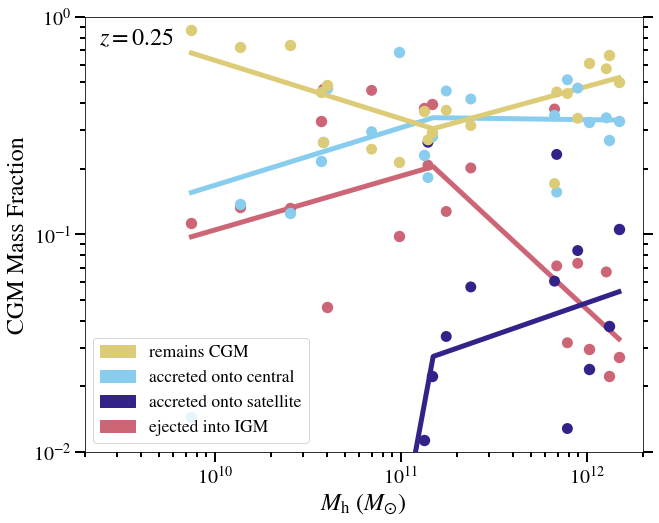

In [40]:
if presentation_figure:
    plt.style.use('dark_background')
    
    # Make the satellite accretion easier to see on a dark background
    l_config.COLORSCHEME['is_CGM_accreted_to_satellite'] = matplotlib.colors.hsv_to_rgb(
        np.array([ 250./360., 0.65, 1. ]),
    )
        
    
fig_facecolor = {
    True: 'k',
    False: 'w',
}

fig = plt.figure( figsize=(10,8), facecolor=fig_facecolor[presentation_figure] )
ax = plt.gca()

# Some plot settings
y_min = 1e-4
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_CGM_FATE ):
        
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
    
    if classification in [ 'is_in_CGM', 'is_CGM_halo_transfer' ]:
        continue
        
    item = CGM_mass_fractions['fate']['all'][classification]
    
    md_split = item.split_by_key_slice( slice(4,10), '_md' )
    fiducials = md_split[False]
    mds = md_split[True]
    
    edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
        l_config.COLORSCHEME[classification]
    ) )
    edgecolor[-1] = alpha
    
    # Default points
    ax.scatter(
        m_vir_fiducials.array(),
        fiducials.array(),
        s = 130,
        color = None,
        zorder = 100 - k,
        linewidth = 0,
        facecolors = l_config.COLORSCHEME[classification],
        alpha = alpha,
    )
    
    if mass_key != 'M':
        facecolors = 'none'
        color = edgecolor
    else:
        facecolors = l_config.COLORSCHEME[classification]
        color = 'none'
        
    # Turbulent metal diffusion
    ax.scatter(
        m_vir_mds.array(),
        mds.array(),
        s = 120,
        color = color,
        marker = 'o',
        zorder = 100 - k,
        facecolors = facecolors,
        linewidth = 3.5,
        alpha = alpha,
    )
    
    # Box plot
    if mass_key != 'M':
        x_data_list = [ m_vir_mds, m_vir_fiducials, ]
        y_data_list = [ mds, fiducials, ]
        linestyles = [ '--', '-', ]
    else:
        x_data_list = [ halo_masses, ]
        y_data_list = [ item, ]
        linestyles = [ '-', ]
    for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
        x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        means = plotting.box_plot(
            x_datas,
            y_datas,
            ax = ax,
            color = l_config.COLORSCHEME[classification],
            box_zorder = 50 - k,
            blank_zorder = 30 - k,
            line_zorder = 10 - k,
    #         linewidth = 7 - k,
            linewidth = 5,
            linestyle = linestyle,
            y_floor = 1e-5,
            plot_boxes = False,
            line_x_min = x_data.array().min(),
            line_x_max = x_data.array().max(),
            y_mean_statistic = np.median,
            return_means = True,
        )
        
    if classification is not None:
        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = l_config.COLORSCHEME[classification],                                 
            ec = l_config.COLORSCHEME[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
        
    ################################################################################
    # Annotate lines   

    if mass_key != 'M':
        # Default args
        if snum == 465:
            xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
            ha = 'right'
        elif snum == 172:
            xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
            ha = 'left'
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[classification],
            'xy' : xy,
            'fontsize' : 22,
            'color' : 'k',
            'va': 'center',
            'ha': ha,
        }

        # Customization
        if classification == 'is_CGM_accreted':
            if snum == 172:
                label_args['xy'][1] *= 1.2
            elif snum == 465:
                label_args['xy'][1] *= 1.4
        elif classification == 'is_CGM_accreted_to_satellite':
            label_args['s'] = 'accreted -\nsatellite'
            if snum == 465:
                label_args['xy'] = [ 1.5*1e11, 7e-3]
                label_args['ha'] = 'left'
        elif classification == 'is_CGM_still':
            label_args['s'] = 'remains\nCGM'
            if snum == 465:
                label_args['xy'][1] *= 1./1.2
        elif classification == 'is_CGM_ejected':
            if snum == 172:
                label_args['xy'][1] *= 1./1.2
            elif snum == 465:
                label_args['xy'][1] *= 1./1.4

        text = ax.annotate( **label_args )

        text.set_path_effects([
            path_effects.Stroke(
                linewidth=3, 
                foreground=l_config.COLORSCHEME[classification],
                alpha = 0.5,
            ),
            path_effects.Normal(),
        ])
        
    # Add a redshift label
    if k == 0:
        redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
        ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

    if snum == 172 or presentation_figure:
        ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'CGM {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

    ax.set_xlim( 2e9, 2e12 )
    ax.set_ylim( y_min, y_max )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )
    
    # Add ticks to the righ
    ax.yaxis.set_ticks_position( 'both' )

    if snum == 465:
        legend = ax.legend(
            color_objects,
            labels,
            prop={'size': 17.5},
            ncol=1,
            loc='lower left',
            fontsize=24,
            framealpha = 0.8,
        )
        legend.set_zorder( 120 )

# if presentation_figure:
    
#     save_file = 'CGM_{}_frac_vs_Mh{}.{}.pdf'.format( save_file_tags[mass_key], tag_tail )

#     plotting.save_fig(
#         out_dir = file_manager.project_parameters['extras_dir'],
#         save_file = save_file,
#         fig = fig,
#     )

fig

## Metal Mass Version

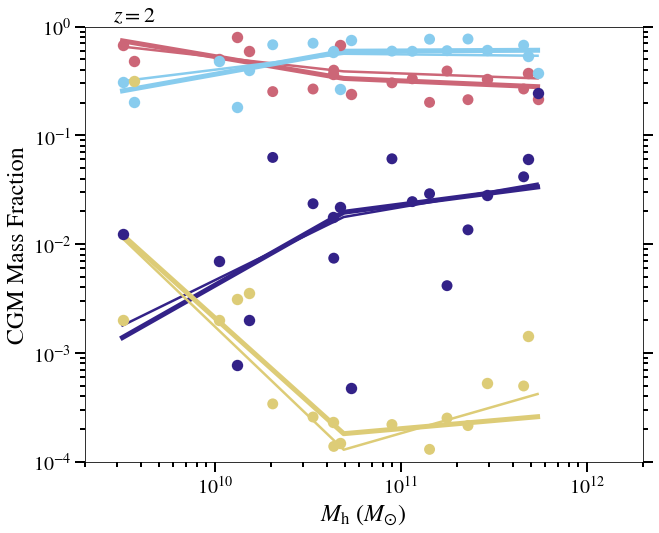

In [38]:
fig = plt.figure( figsize=(10,8), facecolor='w' )
ax = plt.gca()

# Some plot settings
y_min = 1e-4
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_CGM_FATE ):
    
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
    
    if classification in [ 'is_in_CGM', 'is_CGM_halo_transfer' ]:
        continue
        
    item = CGM_mass_fractions['fate']['all'][classification]
    
    md_split = item.split_by_key_slice( slice(4,10), '_md' )
    fiducials = md_split[False]
    mds = md_split[True]
    
    edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
        l_config.COLORSCHEME[classification]
    ) )
    edgecolor[-1] = alpha
        
    # Default points
    ax.scatter(
        m_vir_fiducials.array(),
        fiducials.array(),
        s = 130,
        color = None,
        zorder = 100 - k,
        linewidth = 0,
        facecolors = l_config.COLORSCHEME[classification],
        alpha = alpha,
    )
    
    if mass_key != 'M':
        facecolors = 'none'
        color = edgecolor
    else:
        facecolors = l_config.COLORSCHEME[classification]
        color = 'none'
        
    # Turbulent metal diffusion
    ax.scatter(
        m_vir_mds.array(),
        mds.array(),
        s = 120,
        color = color,
        marker = 'o',
        zorder = 100 - k,
        facecolors = facecolors,
        linewidth = 3.5,
        alpha = alpha,
    )
    
#     # Box plot
#     if mass_key != 'M':
#         x_data_list = [ m_vir_mds, m_vir_fiducials, ]
#         y_data_list = [ mds, fiducials, ]
#         linestyles = [ '--', '-', ]
#     else:
    item_b = b_CGM_mass_fractions['fate']['all'][classification]
    x_data_list = [ halo_masses, halo_masses ]
    y_data_list = [ item, item_b ]
    linewidths = [ 5, 2.5 ]
    for x_data, y_data, linewidth in zip( x_data_list, y_data_list, linewidths ):        
        x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        means = plotting.box_plot(
            x_datas,
            y_datas,
            ax = ax,
            color = l_config.COLORSCHEME[classification],
            box_zorder = 50 - k,
            blank_zorder = 30 - k,
            line_zorder = 10 - k,
    #         linewidth = 7 - k,
            linewidth = linewidth,
            linestyle = '-',
            y_floor = 1e-5,
            plot_boxes = False,
            line_x_min = x_data.array().min(),
            line_x_max = x_data.array().max(),
            y_mean_statistic = np.median,
            return_means = True,
        )
        
    if classification is not None:
        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = l_config.COLORSCHEME[classification],                                 
            ec = l_config.COLORSCHEME[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
        
    ################################################################################
    # Annotate lines   

    if mass_key != 'M':
        # Default args
        if snum == 465:
            xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
            ha = 'right'
        elif snum == 172:
            xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
            ha = 'left'
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[classification],
            'xy' : xy,
            'fontsize' : 22,
            'color' : 'k',
            'va': 'center',
            'ha': ha,
        }

        # Customization
        if classification == 'is_CGM_accreted':
            if snum == 172:
                label_args['xy'][1] *= 1.2
            elif snum == 465:
                label_args['xy'][1] *= 1.4
        elif classification == 'is_CGM_accreted_to_satellite':
            label_args['s'] = 'accreted -\nsatellite'
            if snum == 465:
                label_args['xy'] = [ 1.5*1e11, 7e-3]
                label_args['ha'] = 'left'
        elif classification == 'is_CGM_still':
            label_args['s'] = 'remains\nCGM'
            if snum == 465:
                label_args['xy'][1] *= 1./1.2
        elif classification == 'is_CGM_ejected':
            if snum == 172:
                label_args['xy'][1] *= 1./1.2
            elif snum == 465:
                label_args['xy'][1] *= 1./1.4

#         text = ax.annotate( **label_args )

#         text.set_path_effects([
#             path_effects.Stroke(
#                 linewidth=3, 
#                 foreground=l_config.COLORSCHEME[classification],
#                 alpha = 0.5,
#             ),
#             path_effects.Normal(),
#         ])
        
    # Add a redshift label
    if k == 0:
        redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
        ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

    if snum == 172:
        ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'CGM {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

    ax.set_xlim( 2e9, 2e12 )
    ax.set_ylim( y_min, y_max )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )
    
    # Add ticks to the righ
    ax.yaxis.set_ticks_position( 'both' )

    if snum == 465:
        legend = ax.legend(
            color_objects,
            labels,
            prop={'size': 17.5},
            ncol=1,
            loc='lower left',
            fontsize=24,
            framealpha = 0.8,
        )
        legend.set_zorder( 120 )

save_file = 'CGM_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

if mass_key != 'M':
    plotting.save_fig(
        out_dir = file_manager.get_project_figure_dir(),
        save_file = save_file,
        fig = fig,
    )

fig

## Multi-panel

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/CGM_mass_frac_vs_Mh_CGM_snum172.pdf


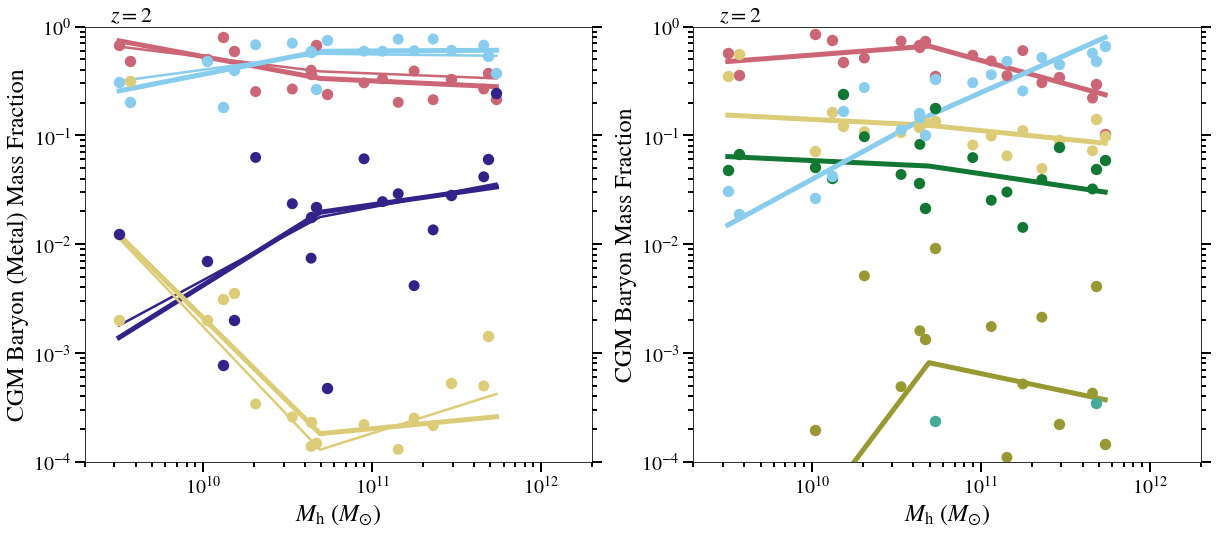

In [39]:
fig = plt.figure( figsize=(20,8), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( 1, 2, )
gs.update( hspace=0.00001 )

ax = plt.subplot( gs[0,0] )

# Some plot settings
y_min = 1e-4
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_CGM_FATE ):
    
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
    
    if classification in [ 'is_in_CGM', 'is_CGM_halo_transfer' ]:
        continue
        
    fid_linestyle = {
        'all': '-',
        'cool': '--',
        'hot': ':',
    }
    fid_marker = {
        'all': 'o',
        'cool': 6,
        'hot': 7,
    }
    
    for t_cut in [ 'all', ]:
        item = CGM_mass_fractions['fate'][t_cut][classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        if t_cut == 'all':

            # Default points
            ax.scatter(
                m_vir_fiducials.array(),
                fiducials.array(),
                marker=fid_marker[t_cut],
                s = 130,
                color = None,
                zorder = 100 - k,
                linewidth = 0,
                facecolors = l_config.COLORSCHEME[classification],
                alpha = alpha,
            )

            if mass_key != 'M':
                facecolors = 'none'
                color = edgecolor
            else:
                facecolors = l_config.COLORSCHEME[classification]
                color = 'none'

            # Turbulent metal diffusion
            ax.scatter(
                m_vir_mds.array(),
                mds.array(),
                marker=fid_marker[t_cut],
                s = 120,
                color = color,
                zorder = 100 - k,
                facecolors = facecolors,
                linewidth = 3.5,
                alpha = alpha,
            )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ fid_linestyle[t_cut], ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            means = plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
                return_means = True,
            )
            
        # Make lines for metal masses
        item_b = b_CGM_mass_fractions['fate']['all'][classification]
        x_datas = halo_masses.split_by_dict( l_config.MASS_BINS, return_list=True )
        y_datas = item_b.split_by_dict( l_config.MASS_BINS, return_list=True )
        means = plotting.box_plot(
            x_datas,
            y_datas,
            ax = ax,
            color = l_config.COLORSCHEME[classification],
            box_zorder = 50 - k,
            blank_zorder = 30 - k,
            line_zorder = 10 - k,
    #         linewidth = 7 - k,
            linewidth = 2.5,
            linestyle = '-',
            y_floor = 1e-5,
            plot_boxes = False,
            line_x_min = x_data.array().min(),
            line_x_max = x_data.array().max(),
            y_mean_statistic = np.median,
            return_means = True,
        )
            
        if classification is not None:
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
        
        if t_cut == 'all':
            
            ################################################################################
            # Annotate lines   

            # Default args
            if snum == 465:
                xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
                ha = 'right'
            elif snum == 172:
                xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
                ha = 'left'
            label_args = {
                's' : p_constants.CLASSIFICATION_LABELS[classification],
                'xy' : xy,
                'fontsize' : 22,
                'color' : 'k',
                'va': 'center',
                'ha': ha,
            }

            # Customization
            if classification == 'is_in_main_gal':
                label_args['s'] = 'main\ngalaxy'
                if snum == 465:
                    label_args['xy'][1] *= 0.9
                elif snum == 172:
                    label_args['xy'][1] *= 1.2
            elif classification == 'is_in_galaxy_halo_interface':
                label_args['s'] = 'galaxy-\nhalo\ninterface'
                if snum == 465:
                    label_args['xy'][1] *= 0.15
                elif snum == 172:
                    label_args['xy'][1] *= 0.5
            elif classification == 'is_in_IGM' and snum == 465:
                    label_args['xy'][1] *= 1.2
            elif classification == 'is_in_other_CGM_not_main':
                label_args['s'] = 'external\nCGM'
                if snum == 465:
                    label_args['xy'] = [ 5e11, 1e-3 ]
            elif classification == 'is_CGM_accreted' and snum == 465:
                label_args['xy'][1] *= 0.9
            elif classification == 'is_CGM_accreted_to_satellite':
                label_args['s'] = 'accreted -\nsatellite'
                if snum == 465:
                    label_args['xy'] = [ 1.5*1e11, 1e-2 ]
                    label_args['ha'] = 'left'
            elif classification == 'is_CGM_still':
                label_args['s'] = 'remains\nCGM'
                if snum == 465:
                    label_args['xy'][1] *= 1.1
            elif classification == 'is_CGM_ejected' and snum == 465:
                label_args['xy'][1] *= 0.7

#             text = ax.annotate( **label_args )

#             text.set_path_effects([
#                 path_effects.Stroke(
#                     linewidth=3, 
#                     foreground=l_config.COLORSCHEME[classification],
#                     alpha = 0.5,
#                 ),
#                 path_effects.Normal(),
#             ])

# Add a redshift label
redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

if snum == 172:
    ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
ax.set_ylabel( r'CGM Baryon (Metal) {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

ax.set_xlim( 2e9, 2e12 )
ax.set_ylim( y_min, y_max )

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

# Add ticks to the righ
ax.yaxis.set_ticks_position( 'both' )

if snum == 465:
    ax.annotate(
        s = 'Proximate Fate',
        xy = ( 0.5, 1. ),
        va = 'bottom',
        ha = 'center',
        xycoords = 'axes fraction',
        fontsize = 28,
    )
    
if snum == 465:
    legend = ax.legend(
        color_objects,
        labels,
        prop={'size': 17.5},
        ncol=1,
        loc='lower left',
        fontsize=24,
        framealpha = 0.8,
    )
    legend.set_zorder( 120 )



fig

ax = plt.subplot( gs[0,1] )

# Some plot settings
y_min = 1e-4
y_max = 1
alpha = 1.0

# Plot data points
color_objects = []
labels = []
j = 0
for k, classification in enumerate( p_constants.CLASSIFICATIONS_LOCATION ):
    
    if presentation_figure:
                
        j = save_plot_stage( fig, 'CGM_{}_frac_vs_Mh{}'.format( save_file_tags[mass_key], tag_tail ), j )
        
    t_cut = 'all'
        
    item = CGM_mass_fractions['fate'][t_cut][classification]
    
    md_split = item.split_by_key_slice( slice(4,10), '_md' )
    fiducials = md_split[False]
    mds = md_split[True]
    
    edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
        l_config.COLORSCHEME[classification]
    ) )
    edgecolor[-1] = alpha
        
    # Default points
    ax.scatter(
        m_vir_fiducials.array(),
        fiducials.array(),
        s = 130,
        color = None,
        zorder = 100 - k,
        linewidth = 0,
        facecolors = l_config.COLORSCHEME[classification],
        alpha = alpha,
    )
    
    if mass_key != 'M':
        facecolors = 'none'
        color = edgecolor
    else:
        facecolors = l_config.COLORSCHEME[classification]
        color = 'none'
        
    # Turbulent metal diffusion
    ax.scatter(
        m_vir_mds.array(),
        mds.array(),
        s = 120,
        color = color,
        marker = 'o',
        zorder = 100 - k,
        facecolors = facecolors,
        linewidth = 3.5,
        alpha = alpha,
    )
    
    # Box plot
    if mass_key != 'M':
        x_data_list = [ m_vir_fiducials, m_vir_mds, ]
        y_data_list = [ fiducials, mds, ]
        linestyles = [ '-', '--', ]
    else:
        x_data_list = [ halo_masses, ]
        y_data_list = [ item, ]
        linestyles = [ '-', ]
    for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
        x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
        means = plotting.box_plot(
            x_datas,
            y_datas,
            ax = ax,
            color = l_config.COLORSCHEME[classification],
            box_zorder = 50 - k,
            blank_zorder = 30 - k,
            line_zorder = 10 - k,
    #         linewidth = 7 - k,
            linewidth = 5,
            linestyle = linestyle,
            y_floor = 1e-5,
            plot_boxes = False,
            line_x_min = x_data.array().min(),
            line_x_max = x_data.array().max(),
            y_mean_statistic = np.median,
            return_means = True,
        )
        
#     # Make lines for metal masses
#     item_b = b_CGM_mass_fractions['fate']['all'][classification]
#     x_datas = halo_masses.split_by_dict( l_config.MASS_BINS, return_list=True )
#     y_datas = item_b.split_by_dict( l_config.MASS_BINS, return_list=True )
#     means = plotting.box_plot(
#         x_datas,
#         y_datas,
#         ax = ax,
#         color = l_config.COLORSCHEME[classification],
#         box_zorder = 50 - k,
#         blank_zorder = 30 - k,
#         line_zorder = 10 - k,
# #         linewidth = 7 - k,
#         linewidth = 2,
#         linestyle = '-',
#         y_floor = 1e-5,
#         plot_boxes = False,
#         line_x_min = x_data.array().min(),
#         line_x_max = x_data.array().max(),
#         y_mean_statistic = np.median,
#         return_means = True,
#     )
    
    if classification is not None:
        # Make virtual artists to allow a legend to appear
        color_object = matplotlib.patches.Rectangle(                         
            (0, 0),                                                          
            1,                                                               
            1,                                                               
            fc = l_config.COLORSCHEME[classification],                                 
            ec = l_config.COLORSCHEME[classification],                                 
            alpha = p_constants.CLASSIFICATION_ALPHA,                        
        )
        color_objects.append( color_object )                                 
        labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
        
        ## Annotate lines   
        
        # Default args
        if snum == 465:
            xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
            ha = 'right'
        elif snum == 172:
            xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
            ha = 'left'
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[classification],
            'xy' : xy,
            'fontsize' : 22,
            'color' : 'k',
            'va': 'center',
            'ha': ha,
        }

        # Customization
        if classification == 'is_in_main_gal':
            label_args['s'] = 'main\ngalaxy'
            if snum == 465:
                label_args['xy'][1] *= 0.9
            elif snum == 172:
                label_args['xy'][1] *= 1.2
        elif classification == 'is_in_galaxy_halo_interface':
            label_args['s'] = 'galaxy-\nhalo\ninterface'
            if snum == 465:
                label_args['xy'][1] *= 0.15
            elif snum == 172:
                label_args['xy'][1] *= 0.6
        elif classification == 'is_in_IGM':
                if snum == 465:
                    label_args['xy'][1] *= 1.2
                elif snum == 172:
                    label_args['xy'][1] *= 0.6
        elif classification == 'is_in_other_CGM_not_main':
            label_args['s'] = 'external\nCGM'
            if snum == 465:
                label_args['xy'] = [ 5e11, 1e-3 ]
        elif classification == 'is_CGM_accreted' and snum == 465:
            label_args['xy'][1] *= 0.9
        elif classification == 'is_CGM_accreted_to_satellite':
            label_args['s'] = 'accreted -\nsatellite'
            if snum == 465:
                label_args['xy'] = [ 1.5*1e11, 1e-2 ]
                label_args['ha'] = 'left'
        elif classification == 'is_CGM_still':
            label_args['s'] = 'remains\nCGM'
            if snum == 465:
                label_args['xy'][1] *= 1.1
        elif classification == 'is_CGM_ejected' and snum == 465:
            label_args['xy'][1] *= 0.7

#         text = ax.annotate( **label_args )

#         text.set_path_effects([
#             path_effects.Stroke(
#                 linewidth=3, 
#                 foreground=l_config.COLORSCHEME[classification],
#                 alpha = 0.45,
#             ),
#             path_effects.Normal(),
#         ])

# Add a redshift label
redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
ax.annotate( s=redshift_label, xy=(0.05,1.0125), xycoords='axes fraction', fontsize=22 )

if snum == 172:
    ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
ax.set_ylabel( r'CGM Baryon {} Fraction'.format( axes_labels[mass_key] ), fontsize=24 )

ax.set_xlim( 2e9, 2e12 )
ax.set_ylim( y_min, y_max )

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

# Add ticks to the right
ax.yaxis.set_ticks_position( 'both' )
        
if snum == 465:
    ax.annotate(
        s = 'Ultimate Fate',
        xy = ( 0.5, 1. ),
        va = 'bottom',
        ha = 'center',
        xycoords = 'axes fraction',
        fontsize = 28,
    )
    
if snum == 465:
    legend = ax.legend(
        color_objects,
        labels,
        prop={'size': 17.5},
        ncol=1,
        loc='lower left',
        fontsize=24,
        framealpha = 0.8,
    )
    legend.set_zorder( 120 )

save_file = 'CGM_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

if mass_key == 'M':
    plotting.save_fig(
        out_dir = file_manager.get_project_figure_dir(),
        save_file = save_file,
        fig = fig,
    )
    
fig

# Connection Between Origin and Fate

File saved at /home1/03057/zhafen/papers/CGM_fate/figures/originfate_mass_frac_vs_Mh_CGM_snum172.pdf


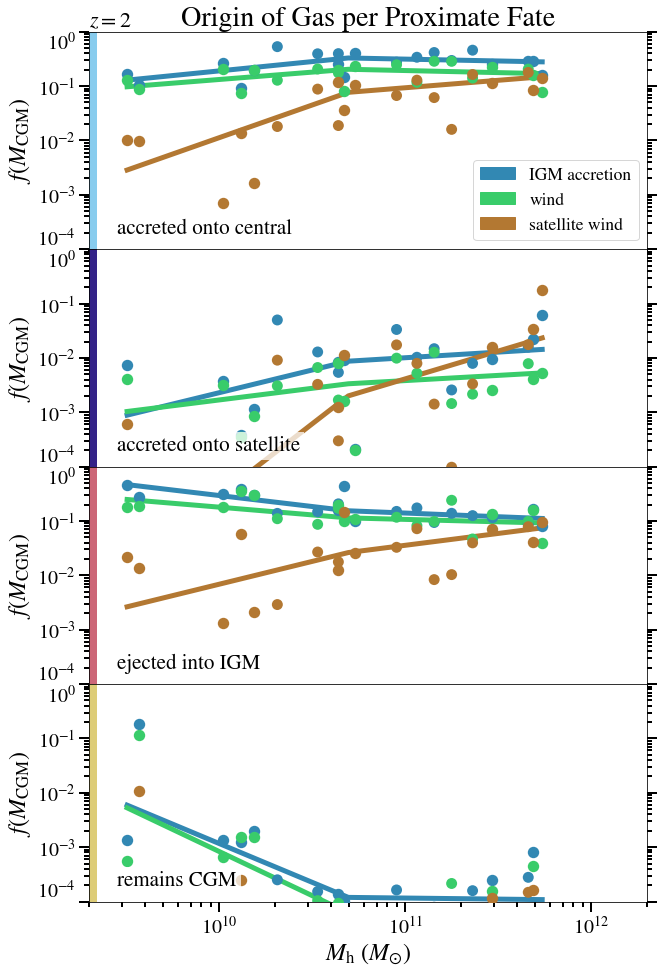

In [40]:
outer_classifications = [ 'is_CGM_accreted', 'is_CGM_accreted_to_satellite', 'is_CGM_ejected', 'is_CGM_still' ]
inner_classifications = p_constants.CLASSIFICATIONS_CGM_ORIGIN

n_rows = len( outer_classifications )

fig = plt.figure( figsize=(10,n_rows*4), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update( hspace=0.00001 )

color_objects = []
labels = []
for i, outer_classification in enumerate( outer_classifications ):
    
    ax = plt.subplot( gs[i,0] )
    
    for j, classification in enumerate( inner_classifications ):
        
        item = CGM_mass_fractions['joint']['all'][outer_classification][classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        # Default points
        ax.scatter(
            m_vir_fiducials.array(),
            fiducials.array(),
            s = 130,
            color = None,
            zorder = 100 - k,
            linewidth = 0,
            facecolors = l_config.COLORSCHEME[classification],
            alpha = alpha,
        )

        if mass_key != 'M':
            facecolors = 'none'
            color = edgecolor
        else:
            facecolors = l_config.COLORSCHEME[classification]
            color = 'none'

        # Turbulent metal diffusion
        ax.scatter(
            m_vir_mds.array(),
            mds.array(),
            s = 120,
            color = color,
            marker = 'o',
            zorder = 100 - k,
            facecolors = facecolors,
            linewidth = 3.5,
            alpha = alpha,
        )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ '-', ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            means = plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
                return_means = True
            )
            
        if classification is not None and classification in inner_classifications and ax.is_first_row():
            
            if classification == 'is_CGM_satellite_ISM':
                continue
            
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
            
        ### Line labels

        # Default args
        if snum == 465:
            xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
            ha = 'right'
        elif snum == 172:
            xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
            ha = 'left'
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[classification],
            'xy' : xy,
            'fontsize' : 22,
            'color' : 'k',
            'va': 'center',
            'ha': ha,
        }

        # Customization
        if classification == 'is_CGM_accreted':
            if outer_classification == 'is_CGM_IGM_accretion' and snum == 465:
                label_args['xy'][0] *= 1.7
                label_args['xy'][1] *= 0.3
            elif outer_classification == 'is_CGM_wind' and snum == 465:
                label_args['xy'] = [ 1.5*1e11, 0.4 ]
                label_args['ha'] = 'left'
            elif outer_classification == 'is_CGM_satellite_wind':
                if snum == 172:
                    label_args['xy'][1] *= 1.1
                elif snum == 465:
                    label_args['xy'] = [ 2e11, 0.15 ]
                    label_args['ha'] = 'left'
        elif classification == 'is_CGM_accreted_to_satellite':
            label_args['s'] = 'accreted -\nsatellite'
            if snum == 465:
                label_args['xy'] = [ 1.5*1e11, 1.5*1e-3 ]
                if outer_classification == 'is_CGM_wind':
                    label_args['xy'] = [ 1.5*1e11, 5e-4 ]
                elif outer_classification == 'is_CGM_satellite_wind':
                    label_args['xy'] = [ 1.2*1e11, 2.2*1e-3 ]
                label_args['ha'] = 'left'
        elif classification == 'is_CGM_still':
            label_args['s'] = 'remains\nCGM'
            if snum == 465:
                if outer_classification == 'is_CGM_wind':
                    label_args['xy'][1] *= 1.75
            if snum == 172:
                label_args['xy'][1] = 3e-4
        elif classification == 'is_CGM_ejected':
            if outer_classification == 'is_CGM_IGM_accretion' and snum == 465:
                label_args['xy'][1] *= 0.6
            elif outer_classification == 'is_CGM_wind':
                if snum == 465:
                    label_args['xy'][1] *= 0.6
                elif snum == 172:
                    label_args['xy'][1] *= 0.7
            elif outer_classification == 'is_CGM_satellite_wind' and snum == 465:
                label_args['xy'][1] *= 0.3
        elif classification == 'is_CGM_IGM_accretion':
            label_args['s'] = 'IGM\naccretion'
        elif classification == 'is_CGM_wind':
            if snum == 465:
                label_args['xy'][1] *= 0.75
            elif snum == 172:
                label_args['xy'][1] *= 0.35
        elif classification == 'is_CGM_satellite_wind':
            label_args['s'] = 'satellite\nwind'
            if snum == 172:
                label_args['xy'][0] *= 0.35
                label_args['xy'][1] *= 0.175

        add_line_labels = ( snum == 465 and ax.is_last_row() ) or ( snum == 172 and ax.is_first_row() )
        if not add_line_labels:
            continue

#         text = ax.annotate( **label_args )

#         text.set_path_effects([
#             path_effects.Stroke(
#                 linewidth=3, 
#                 foreground=l_config.COLORSCHEME[classification],
#                 alpha = 0.45,
#             ),
#             path_effects.Normal(),
#         ])

    # Add a redshift label
    if ax.is_first_row():
        redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
        ax.annotate( s=redshift_label, xy=(0.0,1.), xycoords='axes fraction', va='bottom', fontsize=22 )

    # Classification Labels
    outer_c_label = p_constants.CLASSIFICATION_LABELS[outer_classification]
    if snum == 465:
        outer_c_label = 'proximate fate: ' + outer_c_label
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = outer_c_label,
        xy = ( 0.05, 0.05 ),
        xycoords = 'axes fraction',
        fontsize = 21,
        ha = 'left',
        va = 'bottom',
        zorder = 200,
        bbox = bbox_props,
    )
    
    # Axes Labels
    if ax.is_last_row():
        ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'$f(M_{\rm CGM})$', fontsize=24 )
    
    # Add a colored line for visual signature
    ax.axvline(
        2e9,
        color = l_config.COLORSCHEME[outer_classification],
        linewidth = 15,
    )

    ax.set_xlim( 2e9, 2e12 )
    ax.set_ylim( 1e-4, 1 )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )

    # Avoid overlapping ticks
    ax.get_yticklabels()[1].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-2].set_verticalalignment( 'top' )
    
    # Add ticks to the right
    ax.yaxis.set_ticks_position( 'both' )

    if ax.is_first_row():
        ax.annotate(
            s = 'Origin of Gas per Proximate Fate',
            xy = ( 0.5, 1. ),
            va = 'bottom',
            ha = 'center',
            xycoords = 'axes fraction',
            fontsize = 28,
        )
        

    if ( snum == 172 and ax.is_first_row() ) or ( snum == 465 and ax.is_last_row() ):
        legend = ax.legend(
            color_objects,
            labels,
            prop={'size': 17.5},
            ncol=1,
            loc='lower right',
            fontsize=24,
            framealpha = 0.8,
        )
        legend.set_zorder( 120 )
        
save_file = 'originfate_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
)

fig

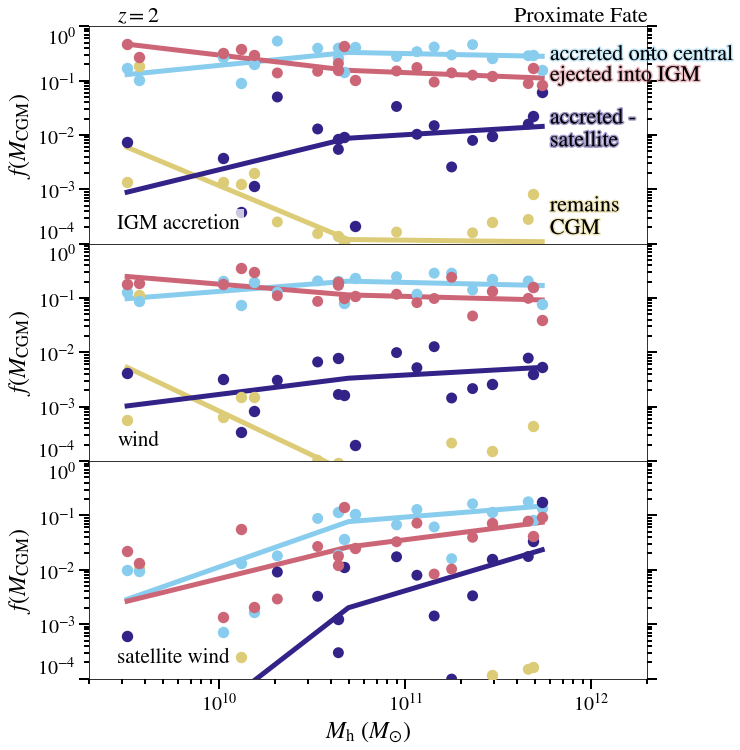

In [41]:
inner_classifications = p_constants.CLASSIFICATIONS_CGM_FATE
outer_classifications = copy.deepcopy( p_constants.CLASSIFICATIONS_CGM_ORIGIN )
outer_classifications.remove( 'is_CGM_satellite_ISM' )

n_rows = len( outer_classifications )

fig = plt.figure( figsize=(10,n_rows*4), facecolor='w' )
main_ax = plt.gca()

gs = matplotlib.gridspec.GridSpec( n_rows, 1, )
gs.update( hspace=0.00001 )

color_objects = []
for i, outer_classification in enumerate( outer_classifications ):
    
    ax = plt.subplot( gs[i,0] )
    
    for j, classification in enumerate( inner_classifications ):
        
        if classification in [ 'is_in_CGM', 'is_CGM_halo_transfer' ]:
            continue
        
        item = CGM_mass_fractions['joint']['all'][classification][outer_classification]

        md_split = item.split_by_key_slice( slice(4,10), '_md' )
        fiducials = md_split[False]
        mds = md_split[True]

        edgecolor = np.array( matplotlib.colors.colorConverter.to_rgba(
            l_config.COLORSCHEME[classification]
        ) )
        edgecolor[-1] = alpha

        # Default points
        ax.scatter(
            m_vir_fiducials.array(),
            fiducials.array(),
            s = 130,
            color = None,
            zorder = 100 - k,
            linewidth = 0,
            facecolors = l_config.COLORSCHEME[classification],
            alpha = alpha,
        )

        if mass_key != 'M':
            facecolors = 'none'
            color = edgecolor
        else:
            facecolors = l_config.COLORSCHEME[classification]
            color = 'none'

        # Turbulent metal diffusion
        ax.scatter(
            m_vir_mds.array(),
            mds.array(),
            s = 120,
            color = color,
            marker = 'o',
            zorder = 100 - k,
            facecolors = facecolors,
            linewidth = 3.5,
            alpha = alpha,
        )

        # Box plot
        if mass_key != 'M':
            x_data_list = [ m_vir_fiducials, m_vir_mds, ]
            y_data_list = [ fiducials, mds, ]
            linestyles = [ '-', '--', ]
        else:
            x_data_list = [ halo_masses, ]
            y_data_list = [ item, ]
            linestyles = [ '-', ]
        for x_data, y_data, linestyle in zip( x_data_list, y_data_list, linestyles ):
            x_datas = x_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            y_datas = y_data.split_by_dict( l_config.MASS_BINS, return_list=True )
            means = plotting.box_plot(
                x_datas,
                y_datas,
                ax = ax,
                color = l_config.COLORSCHEME[classification],
                box_zorder = 50 - k,
                blank_zorder = 30 - k,
                line_zorder = 10 - k,
        #         linewidth = 7 - k,
                linewidth = 5,
                linestyle = linestyle,
                y_floor = 1e-5,
                plot_boxes = False,
                line_x_min = x_data.array().min(),
                line_x_max = x_data.array().max(),
                y_mean_statistic = np.median,
                return_means = True
            )

        if classification is not None and classification in inner_classifications and ax.is_first_row():
            # Make virtual artists to allow a legend to appear
            color_object = matplotlib.patches.Rectangle(                         
                (0, 0),                                                          
                1,                                                               
                1,                                                               
                fc = l_config.COLORSCHEME[classification],                                 
                ec = l_config.COLORSCHEME[classification],                                 
                alpha = p_constants.CLASSIFICATION_ALPHA,                        
            )
            color_objects.append( color_object )                                 
            labels.append( p_constants.CLASSIFICATION_LABELS[classification] )
            
        ## Annotate lines   
        
        # Default args
        if snum == 465:
            xy = [ 0.91*x_data.array().min(), means['y'][np.argmin( means['x'] )] ]
            ha = 'right'
        elif snum == 172:
            xy = [ 1.1*x_data.array().max(), means['y'][np.argmax( means['x'] )] ]
            ha = 'left'
        label_args = {
            's' : p_constants.CLASSIFICATION_LABELS[classification],
            'xy' : xy,
            'fontsize' : 22,
            'color' : 'k',
            'va': 'center',
            'ha': ha,
        }

        # Customization
        if classification == 'is_CGM_accreted':
            if outer_classification == 'is_CGM_IGM_accretion' and snum == 465:
                label_args['xy'][0] *= 1.7
                label_args['xy'][1] *= 0.3
            elif outer_classification == 'is_CGM_wind' and snum == 465:
                label_args['xy'] = [ 1.5*1e11, 0.4 ]
                label_args['ha'] = 'left'
            elif outer_classification == 'is_CGM_satellite_wind':
                if snum == 172:
                    label_args['xy'][1] *= 1.1
                elif snum == 465:
                    label_args['xy'] = [ 2e11, 0.15 ]
                    label_args['ha'] = 'left'
        elif classification == 'is_CGM_accreted_to_satellite':
            label_args['s'] = 'accreted -\nsatellite'
            if snum == 465:
                label_args['xy'] = [ 1.5*1e11, 1.5*1e-3 ]
                if outer_classification == 'is_CGM_wind':
                    label_args['xy'] = [ 1.5*1e11, 5e-4 ]
                elif outer_classification == 'is_CGM_satellite_wind':
                    label_args['xy'] = [ 1.2*1e11, 2.2*1e-3 ]
                label_args['ha'] = 'left'
        elif classification == 'is_CGM_still':
            label_args['s'] = 'remains\nCGM'
            if snum == 465:
                if outer_classification == 'is_CGM_wind':
                    label_args['xy'][1] *= 1.75
            if snum == 172:
                label_args['xy'][1] = 3e-4
        elif classification == 'is_CGM_ejected':
            if outer_classification == 'is_CGM_IGM_accretion' and snum == 465:
                label_args['xy'][1] *= 0.6
            elif outer_classification == 'is_CGM_wind':
                if snum == 465:
                    label_args['xy'][1] *= 0.6
                elif snum == 172:
                    label_args['xy'][1] *= 0.7
            elif outer_classification == 'is_CGM_satellite_wind' and snum == 465:
                label_args['xy'][1] *= 0.3
                
        if not ax.is_first_row():
            continue

        text = ax.annotate( **label_args )

        text.set_path_effects([
            path_effects.Stroke(
                linewidth=3, 
                foreground=l_config.COLORSCHEME[classification],
                alpha = 0.45,
            ),
            path_effects.Normal(),
        ])

    # Add a redshift label
    if ax.is_first_row():
        redshift_label = r'$z=' + '{:.02g}'.format( redshift ) + '$'
        ax.annotate( s=redshift_label, xy=(0.05,1.), xycoords='axes fraction', va='bottom', fontsize=22 )

    # Classification Labels
    outer_c_label = p_constants.CLASSIFICATION_LABELS[outer_classification]
    if snum == 465:
        outer_c_label = 'Origin: ' + outer_c_label
    bbox_props = dict( fc="w", alpha=0.75, lw=0 )
    ax.annotate(
        s = outer_c_label,
        xy = ( 0.05, 0.05 ),
        xycoords = 'axes fraction',
        fontsize = 21,
        ha = 'left',
        va = 'bottom',
        zorder = 200,
        bbox = bbox_props,
    )
    
    # Axes Labels
    if ax.is_last_row():
        ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'$f(M_{\rm CGM})$', fontsize=24 )

    ax.set_xlim( 2e9, 2e12 )
    ax.set_ylim( 1e-4, 1 )

    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )

    # Avoid overlapping ticks
    ax.get_yticklabels()[1].set_verticalalignment( 'bottom' )
    ax.get_yticklabels()[-2].set_verticalalignment( 'top' )
    
    # Add ticks to the right
    ax.yaxis.set_ticks_position( 'both' )

    if ax.is_first_row():
        ax.annotate(
            s = 'Proximate Fate',
            xy = ( 1., 1. ),
            va = 'bottom',
            ha = 'right',
            xycoords = 'axes fraction',
            fontsize = 22,
        )
        
# save_file = 'originfate_{}_frac_vs_Mh{}.pdf'.format( save_file_tags[mass_key], tag_tail )

# plotting.save_fig(
#     out_dir = file_manager.get_project_figure_dir(),
#     save_file = save_file,
#     fig = fig,
# )

fig

# Quantitative Values for the Paper

In [42]:
import os

import py2tex.py2tex as py2tex

In [43]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [44]:
tex_file = py2tex.TeXVariableFile( tex_filepath )

In [45]:
# Used for variable names
tex_redshift = {
    465: 'low',
    172: 'high',
}

In [46]:
tex_mass = {
    'M': 'mass',
    'enriched_metal_mass': 'metalmass',
}

In [47]:
tex_tag = '{}{}'.format( tex_mass[mass_key], tex_redshift[snum] )
tex_tag

'masshigh'

## Load the Origins Data

In [48]:
origins_file_manager = file_management.FileManager( project='CGM_origin' )
mass_budget_data_filepath = os.path.join(
    origins_file_manager.project_parameters['output_data_dir'],
    'halo_mass_content_FIRE2_snum{}.hdf5'.format( snum ),
)
origins_mass_frac_data_filepath = os.path.join(
    origins_file_manager.project_parameters['output_data_dir'],
    'cgm_origins_mass_frac_snum{}.hdf5'.format( snum ),
)

In [49]:
mass_budgets, attributes = verdict.Dict.from_hdf5(
    mass_budget_data_filepath,
    unpack = True,
)
CGM_mass_fracs_origins, attributes = verdict.Dict.from_hdf5(
    origins_mass_frac_data_filepath,
    unpack = True,
)

# Make sure we're not using bytes...
for key, item in CGM_mass_fracs_origins.items():
    
    new_item = {}
    for i_key, i_item in item.items():
        new_item[i_key.decode('utf-8')] = i_item
    
    CGM_mass_fracs_origins[str(key)] = new_item
    
CGM_mass_fracs_origins = verdict.Dict( CGM_mass_fracs_origins )

## Ejected

In [50]:
med_mass_frac = np.median(
    CGM_mass_fractions['fate']['all']['is_CGM_ejected'].split_by_dict( l_config.MASS_BINS )['m12'].array()
)
tex_file.save_variable(
    'percentejectedMW{}'.format( tex_tag ),
    py2tex.to_tex_percentage( med_mass_frac, 5, nearest_base=True )
)

Saving 30\% as percentejectedMWmasshigh


### Dependence on Origins

In [51]:
frac_cat = (
    CGM_mass_fractions['joint']['all']['is_CGM_ejected']['is_CGM_IGM_accretion'] /
    CGM_mass_fractions['joint']['all']['is_in_CGM_not_sat']['is_CGM_IGM_accretion']
)
tex_file.save_variable(
    'percentIGMaccejectedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentIGMaccejectedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat.nanpercentile( 84. ), 5, nearest_base=True )
)

Saving 20 as percentIGMaccejectedminustwosigmamasshigh
Saving 60\% as percentIGMaccejectedplustwosigmamasshigh


## Accreted

In [52]:
minish_mass_low = np.percentile( CGM_mass_fractions['fate']['all']['is_CGM_accreted'].array(), 10 )

tex_file.save_variable(
    'percentaccretedmin{}'.format( tex_tag ),
    py2tex.to_tex_percentage( minish_mass_low, 5, nearest_base=True )
)

Saving 25\% as percentaccretedminmasshigh


In [53]:
CGM_mass_fractions['fate']['all']['is_CGM_accreted'].split_by_dict(
    l_config.MASS_BINS
)['m11'].nanmedian()

0.59412881731987

In [54]:
CGM_mass_fractions['fate']['all']['is_in_IGM'].split_by_dict(
    l_config.MASS_BINS
)['m11'].nanmedian()

0.6631634533405304

In [55]:
CGM_mass_fractions['fate']['all']['is_in_main_gal'].split_by_dict(
    l_config.MASS_BINS
)['m12'].nanmedian()

0.48310990631580353

In [56]:
snum

172

In [57]:
(
    CGM_mass_fractions['fate']['all']['is_in_main_gal'] /
    CGM_mass_fractions['fate']['all']['is_CGM_accreted']
).split_by_dict(
    l_config.MASS_BINS
)['m12'].nanmedian()

0.7101567104821318

In [58]:
minish_mass_low = np.percentile( CGM_mass_fractions['fate']['all']['is_CGM_accreted'].array(), 10 )

tex_file.save_variable(
    'percentaccretedmin{}'.format( tex_tag ),
    py2tex.to_tex_percentage( minish_mass_low, 5, nearest_base=True )
)

Saving 25\% as percentaccretedminmasshigh


### Compare Accreted Mass to Galaxy Mass

In [59]:
accreted_mass = CGM_mass_fractions['fate']['all']['is_CGM_accreted'] * mass_budgets['M']['gas']['m_cgm']
acc_div_gal = accreted_mass / mass_budgets['M']['total']['m_gal']

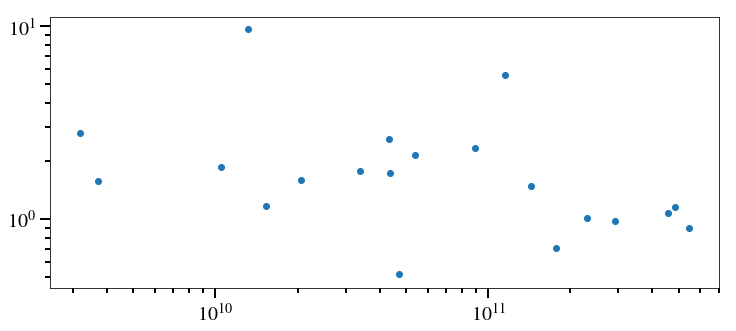

In [60]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

ax.scatter(
    halo_masses.array(),
    acc_div_gal.array(),
)

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

fig

In [61]:
tex_file.save_variable(
    'accdivgalmedian{}'.format( tex_tag ),
    '{:.2g}'.format( np.median( acc_div_gal.array() ) ),
)

Saving 1.6 as accdivgalmedianmasshigh


### Dependence on Origins

#### Fraction of different origins accreted

In [62]:
frac_cat_accreted = (
    CGM_mass_fractions['joint']['all']['is_CGM_accreted']['is_CGM_IGM_accretion'] /
    CGM_mass_fractions['joint']['all']['is_in_CGM_not_sat']['is_CGM_IGM_accretion']
)
tex_file.save_variable(
    'percentIGMaccaccretedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentIGMaccaccretedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 84. ), 5, nearest_base=True )
)

Saving 25 as percentIGMaccaccretedminustwosigmamasshigh
Saving 75\% as percentIGMaccaccretedplustwosigmamasshigh


In [63]:
frac_cat_accreted = (
    CGM_mass_fractions['joint']['all']['is_CGM_accreted']['is_CGM_wind'] /
    CGM_mass_fractions['joint']['all']['is_in_CGM_not_sat']['is_CGM_wind']
)
tex_file.save_variable(
    'percentwindaccretedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentwindaccretedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 84. ), 5, nearest_base=True )
)

Saving 40 as percentwindaccretedminustwosigmamasshigh
Saving 65\% as percentwindaccretedplustwosigmamasshigh


In [64]:
frac_cat_accreted = (
    CGM_mass_fractions['joint']['all']['is_CGM_accreted']['is_CGM_satellite_wind'] /
    CGM_mass_fractions['joint']['all']['is_in_CGM_not_sat']['is_CGM_satellite_wind']
)
tex_file.save_variable(
    'percentsatwindaccretedminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentsatwindaccretedplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_cat_accreted.nanpercentile( 84. ), 5, nearest_base=True )
)

Saving 30 as percentsatwindaccretedminustwosigmamasshigh
Saving 80\% as percentsatwindaccretedplustwosigmamasshigh


#### Fraction of accreted from different origins

In [65]:
frac_acc_IGM_acc = (
    CGM_mass_fractions['joint']['all']['is_CGM_accreted']['is_CGM_IGM_accretion'] /
    CGM_mass_fractions['fate']['all']['is_CGM_accreted']
)

tex_file.save_variable(
    'percentaccretedIGMaccminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_acc_IGM_acc.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentaccretedIGMaccplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac_acc_IGM_acc.nanpercentile( 84. ), 5, nearest_base=True )
)

Saving 45 as percentaccretedIGMaccminustwosigmamasshigh
Saving 55\% as percentaccretedIGMaccplustwosigmamasshigh


## Accreted to Satellite

In [66]:
max_acc_sat = CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'].keymax()
max_acc_sat

('m12m', 0.24467463791370392)

In [67]:
tex_file.save_variable(
    'accsatmax{}'.format( tex_tag ),
    py2tex.to_tex_percentage( max_acc_sat[1], 5, nearest_base=True )
)

Saving 25\% as accsatmaxmasshigh


### Dependence on Origins

In [68]:
frac = (
    CGM_mass_fractions['joint']['all']['is_CGM_accreted_to_satellite']['is_CGM_satellite_wind'] /
    CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite']
)

tex_file.save_variable(
    'percentaccsatsatwindminustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac.nanpercentile( 16. ), 5, nearest_base=True, include_percent=False )
)
tex_file.save_variable(
    'percentaccsatsatwindplustwosigma{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac.nanpercentile( 84. ), 5, nearest_base=True )
)
tex_file.save_variable(
    'percentaccsatsatwindmed{}'.format( tex_tag ),
    py2tex.to_tex_percentage( frac.nanmedian(), 5, nearest_base=True )
)

Saving 5 as percentaccsatsatwindminustwosigmamasshigh
Saving 50\% as percentaccsatsatwindplustwosigmamasshigh
Saving 15\% as percentaccsatsatwindmedmasshigh


### Comparison to Satellite Mass

In [69]:
acc_sat_to_sat = (
    CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'] /
    CGM_mass_fracs_origins['is_CGM_satellite_ISM']
)
acc_sat_to_sat

Dict, {
'm10q' : nan,
'm10y' : inf,
'm10z' : inf,
'm11q' : 0.6010287040633512,
'm11v' : inf,
'm11a' : inf,
'm11b' : inf,
'm11c' : 0.6909520982349006,
'm12i' : 1.161297269875303,
'm12f' : 3.359989297239253,
'm12m' : 1.6508117459739449,
'm11d_md' : 647.7211099840803,
'm11e_md' : inf,
'm11h_md' : 9.311453281028502,
'm11i_md' : 76.73758993888049,
'm12b_md' : 4.271626162471549,
'm12c_md' : inf,
'm12z_md' : 0.6620143378105072,
'm12r_md' : inf,
'm12w_md' : 63.7369984054263,
}

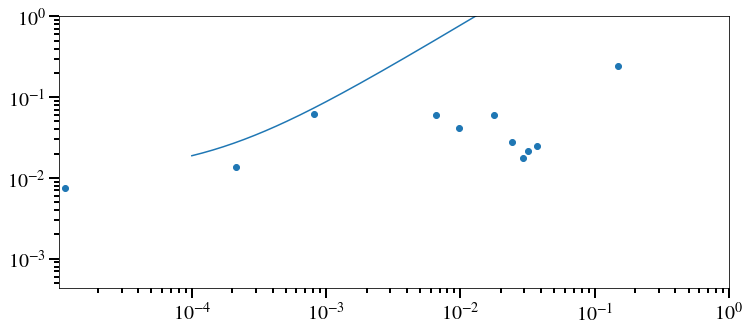

In [70]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

ax.scatter(
    CGM_mass_fracs_origins['is_CGM_satellite_ISM'].array(),
    CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'].array(),
)

# Line
sat_masses = np.logspace( -4., 1., 256 )
possible_slope = np.nanmedian(
    (
        CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'] /
        CGM_mass_fracs_origins['is_CGM_satellite_ISM']
    ).array()
)
acc_sat_masses = (
    possible_slope * (
        sat_masses - np.median( CGM_mass_fracs_origins['is_CGM_satellite_ISM'].array() )
    ) +
    np.median( CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'].array() )
)

ax.plot(
    sat_masses,
    acc_sat_masses
)

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

arr = CGM_mass_fracs_origins['is_CGM_satellite_ISM'].array()
x_min = np.nanmin( arr[arr>0.] )*0.9
arr = CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'].array()
y_min = np.nanmin( arr[arr>0.] )*0.9

ax.set_xlim( x_min, 1., )
ax.set_ylim( y_min, 1., )

fig

## Halo Transfer

In [71]:
CGM_mass_fractions['fate']['all']['is_CGM_halo_transfer'].keymax()

('m11h_md', 0.03217199072241783)

## Still CGM

In [72]:
p = CGM_mass_fractions['fate']['all']['is_CGM_still'].nanpercentile( 16 )

tex_file.save_variable(
    'stillCGMmed{}'.format( tex_tag ),
    py2tex.to_tex_percentage( p, 10, nearest_base=True )
)

Saving 0\% as stillCGMmedmasshigh


# In CGM

## Relative to fraction that stays in the CGM continuously

In [73]:
cgm_min_cgm_still = (
    CGM_mass_fractions['fate']['all']['is_CGM_still'] /
    CGM_mass_fractions['fate']['all']['is_in_CGM']
)
( 1. - cgm_min_cgm_still ).median()

0.9970898578159734

In [74]:
cgm_min_cgm_still = (
    CGM_mass_fractions['fate']['all']['is_in_CGM'] -
    CGM_mass_fractions['fate']['all']['is_CGM_still']
)

tex_file.save_variable(
    'inCGMtoCGMstillmed{}'.format( tex_tag ),
py2tex.to_tex_percentage( cgm_min_cgm_still.median() )
)

Saving 11\% as inCGMtoCGMstillmedmasshigh


## Destination of gas that doesn't end up in the CGM

In [75]:
not_in_CGM = 1. - CGM_mass_fractions['fate']['all']['is_in_CGM']

In [76]:
( CGM_mass_fractions['fate']['all']['is_in_main_gal'] / not_in_CGM ).nanmedian()

0.2983814961988146

In [77]:
( CGM_mass_fractions['fate']['all']['is_in_main_gal'] / not_in_CGM ).split_by_dict(
    l_config.MASS_BINS
)['m11'].nanpercentile( 50 )

0.1731849831143889

In [78]:
( CGM_mass_fractions['fate']['all']['is_in_IGM'] / not_in_CGM ).nanmedian()

0.5855947087441593

In [79]:
( CGM_mass_fractions['fate']['all']['is_in_galaxy_halo_interface'] / not_in_CGM ).nanmedian()

0.056018248971765355

In [80]:
not_remains_CGM = 1. - CGM_mass_fractions['fate']['all']['is_CGM_still']

In [81]:
( CGM_mass_fractions['fate']['all']['is_CGM_accreted'] / not_remains_CGM ).split_by_dict(
    l_config.MASS_BINS
)['m12'].nanpercentile( 50 )

0.6029572303544422

## Comparison to Ford+2014

In [82]:
result = {
    True: {},
    False: {},
}
for key, acc in CGM_mass_fractions['fate']['all']['is_CGM_accreted'].items():
    big_mass = halo_masses[key] > 10**11.5
    result[big_mass][key] = acc + CGM_mass_fractions['fate']['all']['is_CGM_accreted_to_satellite'][key]
result = verdict.Dict( result )

In [83]:
tex_file.save_variable(
    'Fordcomphighmass{}'.format( tex_tag ),
    py2tex.to_tex_percentage( result[True].median(), 10, nearest_base=True )
)

tex_file.save_variable(
    'Fordcomplowmass{}'.format( tex_tag ),
    py2tex.to_tex_percentage( result[False].median(), 10, nearest_base=True )
)

Saving 60\% as Fordcomphighmassmasshigh
Saving 60\% as Fordcomplowmassmasshigh


In [84]:
py2tex.to_tex_scientific_notation(
    mass_budgets['M']['gas']['m_cgm'].split_by_dict( l_config.MASS_BINS )['m12'].nanmedian() * 0.8
)

'10^{10}'

In [85]:
py2tex.to_tex_scientific_notation(
    mass_budgets['M']['gas']['m_cgm'].split_by_dict( l_config.MASS_BINS )['m12'].nanmedian() * 0.8 * 0.3
)

'4\\times10^{9}'